In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip


--2024-12-17 01:44:57--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2024-12-17 01:44:57--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  22.2MB/s    in 10s     

2024-12-17 01:45:08 (22.8 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
import os
import shutil

# Paths
val_dir = './tiny-imagenet-200/val'
val_img_dir = os.path.join(val_dir, 'images')
val_annotations = os.path.join(val_dir, 'val_annotations.txt')

# Read the validation annotations file
with open(val_annotations, 'r') as f:
    lines = f.readlines()

# Create class-wise folders for validation data
for line in lines:
    parts = line.split('\t')
    file_name = parts[0]
    class_name = parts[1]
    class_dir = os.path.join(val_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    # Move image to the corresponding class folder
    shutil.move(os.path.join(val_img_dir, file_name), os.path.join(class_dir, file_name))

# Remove the now-empty images directory
shutil.rmtree(val_img_dir)


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to TinyImageNet size
    transforms.ToTensor(),       # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])
train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val'

dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(val_dir, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
print("Number of classes:", len(dataset.classes))  # Should be 200
print("Example train label:", dataset.targets[0])  # Check a label
print("Train dataset size:", len(dataset))
print("Validation dataset size:", len(test_dataloader))


Number of classes: 200
Example train label: 0
Train dataset size: 100000
Validation dataset size: 313


Cholesky

Using device: cuda


Epoch 1 Training (with Cholesky): 100%|██████████| 3125/3125 [01:43<00:00, 30.08it/s]


Test Accuracy without Cholesky: 4.72%
Test Accuracy with Cholesky: 4.53%


Epoch 2 Training (with Cholesky): 100%|██████████| 3125/3125 [01:46<00:00, 29.27it/s]


Test Accuracy without Cholesky: 5.92%
Test Accuracy with Cholesky: 5.66%


Epoch 3 Training (with Cholesky): 100%|██████████| 3125/3125 [01:43<00:00, 30.20it/s]


Test Accuracy without Cholesky: 6.23%
Test Accuracy with Cholesky: 6.61%


Epoch 4 Training (with Cholesky): 100%|██████████| 3125/3125 [01:44<00:00, 30.01it/s]


Test Accuracy without Cholesky: 7.78%
Test Accuracy with Cholesky: 7.26%


Epoch 5 Training (with Cholesky): 100%|██████████| 3125/3125 [01:46<00:00, 29.45it/s]


Test Accuracy without Cholesky: 8.78%
Test Accuracy with Cholesky: 8.75%


Epoch 6 Training (with Cholesky): 100%|██████████| 3125/3125 [01:43<00:00, 30.31it/s]


Test Accuracy without Cholesky: 9.59%
Test Accuracy with Cholesky: 9.71%


Epoch 7 Training (with Cholesky): 100%|██████████| 3125/3125 [01:40<00:00, 31.22it/s]


Test Accuracy without Cholesky: 10.42%
Test Accuracy with Cholesky: 10.42%


Epoch 8 Training (with Cholesky): 100%|██████████| 3125/3125 [01:40<00:00, 31.00it/s]


Test Accuracy without Cholesky: 10.84%
Test Accuracy with Cholesky: 10.85%


Epoch 9 Training (with Cholesky): 100%|██████████| 3125/3125 [01:41<00:00, 30.87it/s]


Test Accuracy without Cholesky: 11.82%
Test Accuracy with Cholesky: 11.59%


Epoch 10 Training (with Cholesky): 100%|██████████| 3125/3125 [01:39<00:00, 31.32it/s]


Test Accuracy without Cholesky: 11.33%
Test Accuracy with Cholesky: 11.59%

--- Summary of Results ---
Total Time (without Cholesky): 1052.79 seconds
Total Memory (without Cholesky): 81154560 bytes
Average Accuracy (without Cholesky): 8.74%
Total Time (with Cholesky): 1029.49 seconds
Total Memory (with Cholesky): 62710272 bytes
Average Accuracy (with Cholesky): 8.70%


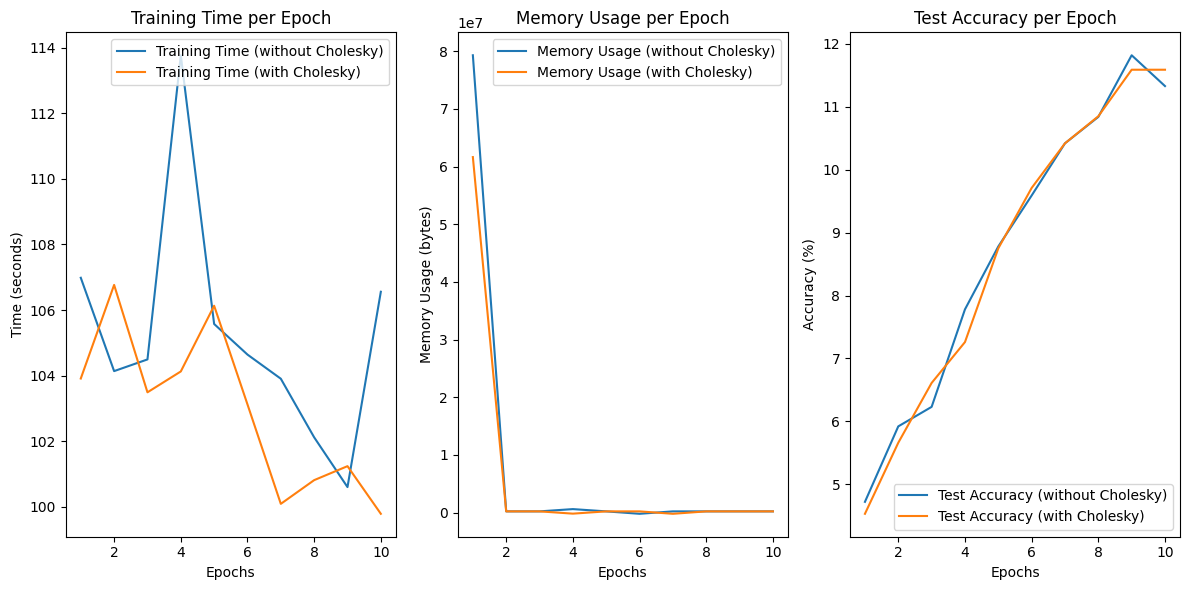

In [ ]:
import torch
import torch.nn as nn
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with Cholesky decomposition
class TransformerBlockCholesky(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.cholesky_factor = None

    def forward(self, x):
        x2 = self.layernorm1(x)
        x = x + self.attn(x2, x2, x2)[0]  # Self-attention
        if self.cholesky_factor is None:
            self.cholesky_factor = self._cholesky_decomposition(x)
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def _cholesky_decomposition(self, x):
        attn_matrix = torch.matmul(x, x.transpose(-2, -1))
        L = torch.linalg.cholesky(attn_matrix)  # Cholesky decomposition
        return L

# Main model with Cholesky blocks
class CustomVisionTransformerCholesky(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockCholesky(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Model without Cholesky decomposition
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockCholesky(embed_dim, num_heads) for _ in range(depth)])  # Same block as above
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Load and prepare data
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val'

dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(val_dir, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Initialize models and optimizers
model = CustomVisionTransformer(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=200).to(device)
model_cholesky = CustomVisionTransformerCholesky(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=200).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_cholesky = torch.optim.Adam(model_cholesky.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times_no_cholesky, train_times_with_cholesky = [], []
train_memories_no_cholesky, train_memories_with_cholesky = [], []
test_accuracies_no_cholesky, test_accuracies_with_cholesky = [], []

# Training models
for epoch in range(10):
    # Train model without Cholesky
    model.train()
    epoch_start_time_no_cholesky = time.time()
    epoch_start_mem_no_cholesky = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (no Cholesky)"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    epoch_end_time_no_cholesky = time.time()
    epoch_end_mem_no_cholesky = get_memory_usage()

    train_times_no_cholesky.append(epoch_end_time_no_cholesky - epoch_start_time_no_cholesky)
    train_memories_no_cholesky.append(epoch_end_mem_no_cholesky - epoch_start_mem_no_cholesky)

    # Test accuracy for model without Cholesky
    model.eval()
    correct_no_cholesky, total_no_cholesky = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_no_cholesky += (predicted == labels).sum().item()

            total_no_cholesky += labels.size(0)

    test_accuracy_no_cholesky = correct_no_cholesky / total_no_cholesky * 100
    test_accuracies_no_cholesky.append(test_accuracy_no_cholesky)

    # Train model with Cholesky
    model_cholesky.train()
    epoch_start_time_with_cholesky = time.time()
    epoch_start_mem_with_cholesky = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (with Cholesky)"):
        images, labels = images.to(device), labels.to(device)

        optimizer_cholesky.zero_grad()
        outputs_cholesky = model_cholesky(images)
        loss_cholesky = loss_fn(outputs_cholesky, labels)
        loss_cholesky.backward()
        optimizer_cholesky.step()

    epoch_end_time_with_cholesky = time.time()
    epoch_end_mem_with_cholesky = get_memory_usage()

    train_times_with_cholesky.append(epoch_end_time_with_cholesky - epoch_start_time_with_cholesky)
    train_memories_with_cholesky.append(epoch_end_mem_with_cholesky - epoch_start_mem_with_cholesky)

    # Test accuracy for model with Cholesky
    model_cholesky.eval()
    correct_with_cholesky, total_with_cholesky = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs_cholesky = model_cholesky(images)
            _, predicted_cholesky = torch.max(outputs_cholesky, 1)
            correct_with_cholesky += (predicted_cholesky == labels).sum().item()

            total_with_cholesky += labels.size(0)

    test_accuracy_with_cholesky = correct_with_cholesky / total_with_cholesky * 100
    test_accuracies_with_cholesky.append(test_accuracy_with_cholesky)

    print(f"Test Accuracy without Cholesky: {test_accuracy_no_cholesky:.2f}%")
    print(f"Test Accuracy with Cholesky: {test_accuracy_with_cholesky:.2f}%")

# Print summary of results
print("\n--- Summary of Results ---")
print(f"Total Time (without Cholesky): {sum(train_times_no_cholesky):.2f} seconds")
print(f"Total Memory (without Cholesky): {sum(train_memories_no_cholesky)} bytes")
print(f"Average Accuracy (without Cholesky): {sum(test_accuracies_no_cholesky) / len(test_accuracies_no_cholesky):.2f}%")

print(f"Total Time (with Cholesky): {sum(train_times_with_cholesky):.2f} seconds")
print(f"Total Memory (with Cholesky): {sum(train_memories_with_cholesky)} bytes")
print(f"Average Accuracy (with Cholesky): {sum(test_accuracies_with_cholesky) / len(test_accuracies_with_cholesky):.2f}%")

# Optionally, you can plot the results if needed
plt.figure(figsize=(12, 6))

# Training time plot
plt.subplot(1, 3, 1)
plt.plot(range(1, 11), train_times_no_cholesky, label="Training Time (without Cholesky)")
plt.plot(range(1, 11), train_times_with_cholesky, label="Training Time (with Cholesky)")
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.legend()

# Memory usage plot
plt.subplot(1, 3, 2)
plt.plot(range(1, 11), train_memories_no_cholesky, label="Memory Usage (without Cholesky)")
plt.plot(range(1, 11), train_memories_with_cholesky, label="Memory Usage (with Cholesky)")
plt.xlabel('Epochs')
plt.ylabel('Memory Usage (bytes)')
plt.title('Memory Usage per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 3)
plt.plot(range(1, 11), test_accuracies_no_cholesky, label="Test Accuracy (without Cholesky)")
plt.plot(range(1, 11), test_accuracies_with_cholesky, label="Test Accuracy (with Cholesky)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

SVD

Using device: cuda


Epoch 1 Training SVD: 100%|██████████| 3125/3125 [05:12<00:00, 10.00it/s]


Test Accuracy with SVD: 4.53%


Epoch 1 Training No SVD: 100%|██████████| 3125/3125 [01:40<00:00, 31.15it/s]


Test Accuracy without SVD: 5.09%


Epoch 2 Training SVD: 100%|██████████| 3125/3125 [05:12<00:00,  9.99it/s]


Test Accuracy with SVD: 6.02%


Epoch 2 Training No SVD: 100%|██████████| 3125/3125 [01:39<00:00, 31.28it/s]


Test Accuracy without SVD: 6.44%


Epoch 3 Training SVD: 100%|██████████| 3125/3125 [05:11<00:00, 10.04it/s]


Test Accuracy with SVD: 6.97%


Epoch 3 Training No SVD: 100%|██████████| 3125/3125 [01:41<00:00, 30.90it/s]


Test Accuracy without SVD: 7.26%


Epoch 4 Training SVD: 100%|██████████| 3125/3125 [05:10<00:00, 10.07it/s]


Test Accuracy with SVD: 7.47%


Epoch 4 Training No SVD: 100%|██████████| 3125/3125 [01:40<00:00, 31.10it/s]


Test Accuracy without SVD: 8.06%


Epoch 5 Training SVD: 100%|██████████| 3125/3125 [05:09<00:00, 10.10it/s]


Test Accuracy with SVD: 8.42%


Epoch 5 Training No SVD: 100%|██████████| 3125/3125 [01:40<00:00, 31.12it/s]


Test Accuracy without SVD: 8.64%


Epoch 6 Training SVD: 100%|██████████| 3125/3125 [05:08<00:00, 10.13it/s]


Test Accuracy with SVD: 9.61%


Epoch 6 Training No SVD: 100%|██████████| 3125/3125 [01:40<00:00, 31.21it/s]


Test Accuracy without SVD: 9.08%


Epoch 7 Training SVD: 100%|██████████| 3125/3125 [05:09<00:00, 10.09it/s]


Test Accuracy with SVD: 10.31%


Epoch 7 Training No SVD: 100%|██████████| 3125/3125 [01:39<00:00, 31.40it/s]


Test Accuracy without SVD: 10.11%


Epoch 8 Training SVD: 100%|██████████| 3125/3125 [05:09<00:00, 10.08it/s]


Test Accuracy with SVD: 11.06%


Epoch 8 Training No SVD: 100%|██████████| 3125/3125 [01:40<00:00, 31.00it/s]


Test Accuracy without SVD: 10.95%


Epoch 9 Training SVD: 100%|██████████| 3125/3125 [05:09<00:00, 10.11it/s]


Test Accuracy with SVD: 11.19%


Epoch 9 Training No SVD: 100%|██████████| 3125/3125 [01:40<00:00, 31.18it/s]


Test Accuracy without SVD: 11.41%


Epoch 10 Training SVD: 100%|██████████| 3125/3125 [05:10<00:00, 10.08it/s]


Test Accuracy with SVD: 11.37%


Epoch 10 Training No SVD: 100%|██████████| 3125/3125 [01:41<00:00, 30.85it/s]


Test Accuracy without SVD: 11.71%

--- Summary of Results ---
Total Time (with SVD): 3103.29 seconds
Total Memory (with SVD): 58987520 bytes
Average Accuracy (with SVD): 8.70%
Total Time (without SVD): 1004.30 seconds
Total Memory (without SVD): 61743104 bytes
Average Accuracy (without SVD): 8.87%


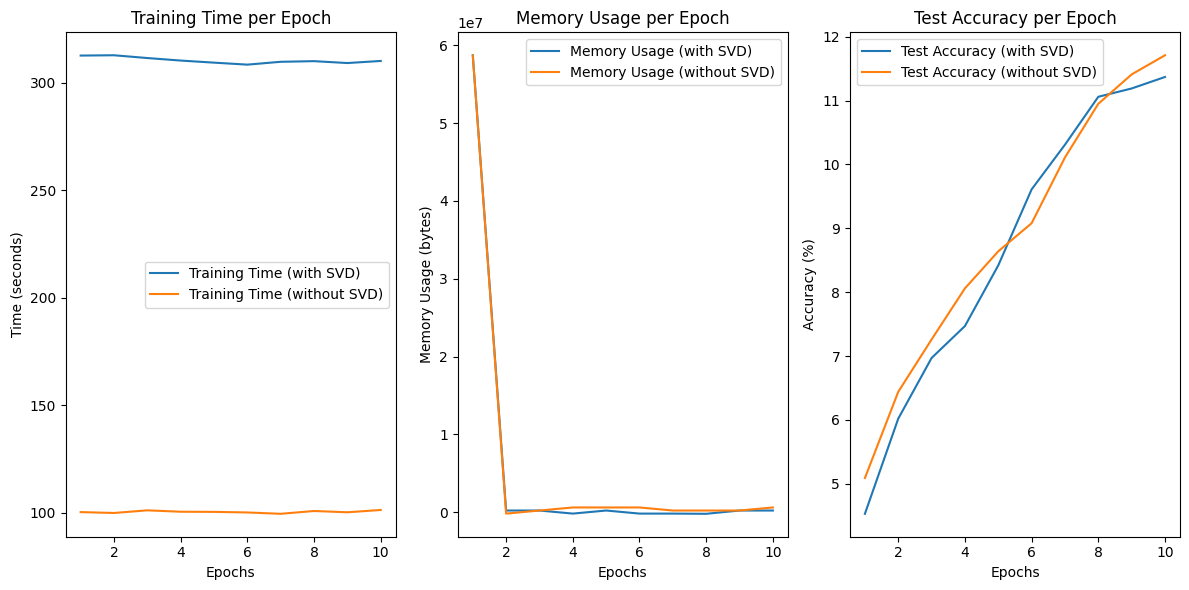

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with SVD decomposition
class TransformerBlockSVD(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.svd_factor = None

    def forward(self, x):
        x2 = self.layernorm1(x)
        attn_output, _ = self.attn(x2, x2, x2)  # Self-attention
        attn_output = self._svd_decomposition(attn_output)
        x = x + attn_output  # Adding the SVD-decoded attention output
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def _svd_decomposition(self, attn_output):
        # Apply SVD to the attention output
        batch_size, seq_len, embed_dim = attn_output.size()

        # Flatten for SVD computation
        attn_matrix = attn_output.view(batch_size * seq_len, embed_dim)

        # Perform SVD
        U, S, V = torch.svd(attn_matrix)  # SVD decomposition
        S = torch.diag(S)  # Create diagonal matrix for singular values
        attn_output_reduced = torch.matmul(U, torch.matmul(S, V.T))

        # Reshape back to the attention output shape
        attn_output_reduced = attn_output_reduced.view(batch_size, seq_len, embed_dim)
        return attn_output_reduced

# Transformer block without SVD
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x2 = self.layernorm1(x)
        attn_output, _ = self.attn(x2, x2, x2)  # Self-attention
        x = x + attn_output  # Adding attention output
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

# Model with SVD blocks
class CustomVisionTransformerSVD(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockSVD(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Model without SVD blocks
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlock(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Load and prepare data
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val'

dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(val_dir, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize models and optimizers
model_svd = CustomVisionTransformerSVD(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=200).to(device)
model_no_svd = CustomVisionTransformer(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=200).to(device)

optimizer_svd = torch.optim.Adam(model_svd.parameters(), lr=1e-4)
optimizer_no_svd = torch.optim.Adam(model_no_svd.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times_svd, train_memories_svd, test_accuracies_svd = [], [], []
train_times_no_svd, train_memories_no_svd, test_accuracies_no_svd = [], [], []

# Training model with SVD
for epoch in range(10):
    # Train with SVD
    model_svd.train()
    epoch_start_time = time.time()
    epoch_start_mem = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training SVD"):
        images, labels = images.to(device), labels.to(device)
        optimizer_svd.zero_grad()
        outputs = model_svd(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_svd.step()

    epoch_end_time = time.time()
    epoch_end_mem = get_memory_usage()

    train_times_svd.append(epoch_end_time - epoch_start_time)
    train_memories_svd.append(epoch_end_mem - epoch_start_mem)

    # Evaluate accuracy
    model_svd.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_svd(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy_svd = correct / total * 100
    test_accuracies_svd.append(test_accuracy_svd)

    print(f"Test Accuracy with SVD: {test_accuracy_svd:.2f}%")

    # Train without SVD
    model_no_svd.train()
    epoch_start_time = time.time()
    epoch_start_mem = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training No SVD"):
        images, labels = images.to(device), labels.to(device)
        optimizer_no_svd.zero_grad()
        outputs = model_no_svd(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_no_svd.step()

    epoch_end_time = time.time()
    epoch_end_mem = get_memory_usage()

    train_times_no_svd.append(epoch_end_time - epoch_start_time)
    train_memories_no_svd.append(epoch_end_mem - epoch_start_mem)

    # Evaluate accuracy
    model_no_svd.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_no_svd(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy_no_svd = correct / total * 100
    test_accuracies_no_svd.append(test_accuracy_no_svd)

    print(f"Test Accuracy without SVD: {test_accuracy_no_svd:.2f}%")

# Summarize results
total_time_svd = sum(train_times_svd)
total_memory_svd = sum(train_memories_svd)
total_accuracy_svd = sum(test_accuracies_svd) / len(test_accuracies_svd)

total_time_no_svd = sum(train_times_no_svd)
total_memory_no_svd = sum(train_memories_no_svd)
total_accuracy_no_svd = sum(test_accuracies_no_svd) / len(test_accuracies_no_svd)

# Print summarized results
print("\n--- Summary of Results ---")
print(f"Total Time (with SVD): {total_time_svd:.2f} seconds")
print(f"Total Memory (with SVD): {total_memory_svd} bytes")
print(f"Average Accuracy (with SVD): {total_accuracy_svd:.2f}%")

print(f"Total Time (without SVD): {total_time_no_svd:.2f} seconds")
print(f"Total Memory (without SVD): {total_memory_no_svd} bytes")
print(f"Average Accuracy (without SVD): {total_accuracy_no_svd:.2f}%")

# Optionally, you can plot the results if needed
plt.figure(figsize=(12, 6))

# Training time plot
plt.subplot(1, 3, 1)
plt.plot(range(1, 11), train_times_svd, label="Training Time (with SVD)")
plt.plot(range(1, 11), train_times_no_svd, label="Training Time (without SVD)")
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.legend()

# Memory usage plot
plt.subplot(1, 3, 2)
plt.plot(range(1, 11), train_memories_svd, label="Memory Usage (with SVD)")
plt.plot(range(1, 11), train_memories_no_svd, label="Memory Usage (without SVD)")
plt.xlabel('Epochs')
plt.ylabel('Memory Usage (bytes)')
plt.title('Memory Usage per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 3)
plt.plot(range(1, 11), test_accuracies_svd, label="Test Accuracy (with SVD)")
plt.plot(range(1, 11), test_accuracies_no_svd, label="Test Accuracy (without SVD)")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

PCA

Using device: cuda


Epoch 10 Training (with PCA): 100%|██████████| 3125/3125 [01:47<00:00, 29.14it/s]



--- Summary of Results ---
Average Training Time (without PCA): 106.03 seconds/epoch
Average Memory Usage (without PCA): -1727027.20 MB/epoch
Average Test Accuracy (without PCA): 8.58%
Average Training Time (with PCA): 105.81 seconds/epoch
Average Memory Usage (with PCA): 6018150.40 MB/epoch
Average Test Accuracy (with PCA): 8.70%


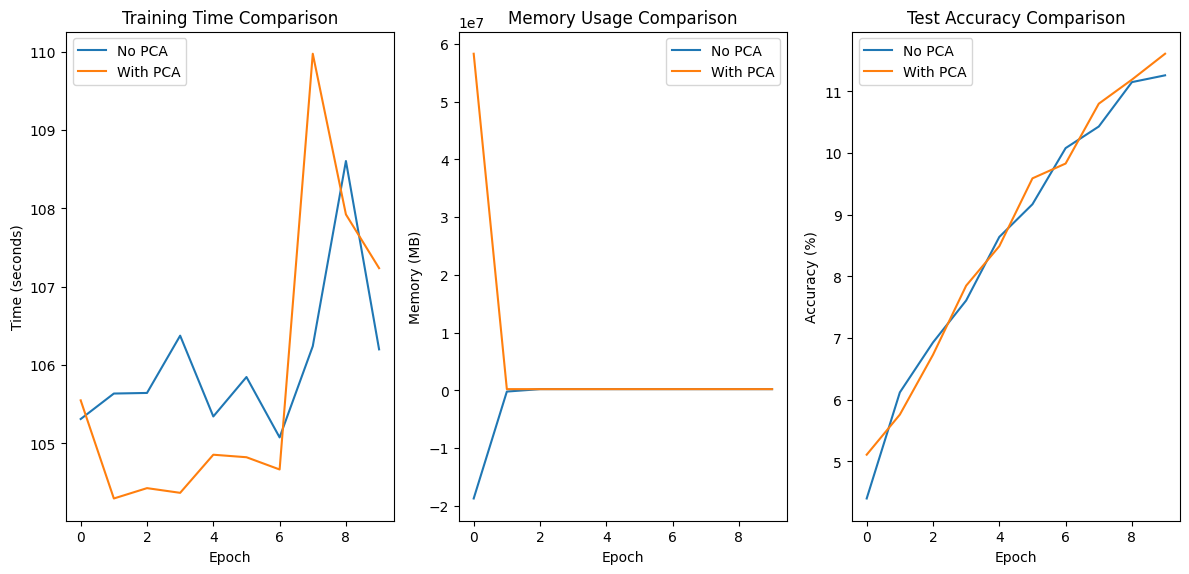

In [ ]:
import torch
import torch.nn as nn
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with PCA-based low-rank approximation
class TransformerBlockPCA(nn.Module):
    def __init__(self, embed_dim, num_heads, rank=64):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.rank = rank  # Rank for low-rank approximation using PCA

    def forward(self, x):
        x2 = self.layernorm1(x)
        x = x + self.attn(x2, x2, x2)[0]  # Self-attention
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def pca_low_rank_approximation(self, attn_matrix):
        # Apply PCA with truncation for low-rank approximation
        pca = PCA(n_components=self.rank)
        attn_matrix = attn_matrix.cpu().numpy()  # Convert tensor to numpy
        attn_matrix_pca = pca.fit_transform(attn_matrix)  # Perform PCA
        attn_matrix_low_rank = pca.inverse_transform(attn_matrix_pca)  # Inverse transform to get low-rank approximation
        return torch.tensor(attn_matrix_low_rank).to(attn_matrix.device)  # Convert back to tensor

# Main model with PCA-based low-rank approximation blocks
class CustomVisionTransformerPCA(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10, rank=64):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes
        self.rank = rank

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockPCA(embed_dim, num_heads, rank) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Model without PCA-based low-rank approximation
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockPCA(embed_dim, num_heads) for _ in range(depth)])  # Same block as above
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Load and prepare data
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val'

dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(val_dir, transform=transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize models and optimizers
model = CustomVisionTransformer(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=200).to(device)
model_pca = CustomVisionTransformerPCA(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=200, rank=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_pca = torch.optim.Adam(model_pca.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times_no_pca, train_times_with_pca = [], []
train_memories_no_pca, train_memories_with_pca = [], []
test_accuracies_no_pca, test_accuracies_with_pca = [], []

# Training models
for epoch in range(10):
    # Train model without PCA
    model.train()
    epoch_start_time_no_pca = time.time()
    epoch_start_mem_no_pca = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (no PCA)"):

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    epoch_end_time_no_pca = time.time()
    epoch_end_mem_no_pca = get_memory_usage()

    train_times_no_pca.append(epoch_end_time_no_pca - epoch_start_time_no_pca)
    train_memories_no_pca.append(epoch_end_mem_no_pca - epoch_start_mem_no_pca)

    # Test accuracy for model without PCA
    model.eval()
    correct_no_pca, total_no_pca = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_no_pca += (predicted == labels).sum().item()

            total_no_pca += labels.size(0)

    test_accuracy_no_pca = correct_no_pca / total_no_pca * 100
    test_accuracies_no_pca.append(test_accuracy_no_pca)

    # Train model with PCA
    model_pca.train()
    epoch_start_time_with_pca = time.time()
    epoch_start_mem_with_pca = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (with PCA)"):

        images, labels = images.to(device), labels.to(device)

        optimizer_pca.zero_grad()
        outputs_pca = model_pca(images)
        loss_pca = loss_fn(outputs_pca, labels)
        loss_pca.backward()
        optimizer_pca.step()

    epoch_end_time_with_pca = time.time()
    epoch_end_mem_with_pca = get_memory_usage()

    train_times_with_pca.append(epoch_end_time_with_pca - epoch_start_time_with_pca)
    train_memories_with_pca.append(epoch_end_mem_with_pca - epoch_start_mem_with_pca)

    # Test accuracy for model with PCA
    model_pca.eval()
    correct_with_pca, total_with_pca = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs_pca = model_pca(images)
            _, predicted = torch.max(outputs_pca, 1)
            correct_with_pca += (predicted == labels).sum().item()

            total_with_pca += labels.size(0)

    test_accuracy_with_pca = correct_with_pca / total_with_pca * 100
    test_accuracies_with_pca.append(test_accuracy_with_pca)

# Print summarized results
print("\n--- Summary of Results ---")
print(f"Average Training Time (without PCA): {sum(train_times_no_pca) / len(train_times_no_pca):.2f} seconds/epoch")
print(f"Average Memory Usage (without PCA): {sum(train_memories_no_pca) / len(train_memories_no_pca):.2f} MB/epoch")
print(f"Average Test Accuracy (without PCA): {sum(test_accuracies_no_pca) / len(test_accuracies_no_pca):.2f}%")

print(f"Average Training Time (with PCA): {sum(train_times_with_pca) / len(train_times_with_pca):.2f} seconds/epoch")
print(f"Average Memory Usage (with PCA): {sum(train_memories_with_pca) / len(train_memories_with_pca):.2f} MB/epoch")
print(f"Average Test Accuracy (with PCA): {sum(test_accuracies_with_pca) / len(test_accuracies_with_pca):.2f}%")

# Plot results
plt.figure(figsize=(12, 6))

# Training time comparison
plt.subplot(1, 3, 1)
plt.plot(train_times_no_pca, label="No PCA")
plt.plot(train_times_with_pca, label="With PCA")
plt.title("Training Time Comparison")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.legend()

# Memory usage comparison
plt.subplot(1, 3, 2)
plt.plot(train_memories_no_pca, label="No PCA")
plt.plot(train_memories_with_pca, label="With PCA")
plt.title("Memory Usage Comparison")
plt.xlabel("Epoch")
plt.ylabel("Memory (MB)")
plt.legend()

# Accuracy comparison
plt.subplot(1, 3, 3)
plt.plot(test_accuracies_no_pca, label="No PCA")
plt.plot(test_accuracies_with_pca, label="With PCA")
plt.title("Test Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


Tensor Decomposition

Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Epoch 10 Training (with Tensor Decomposition): 100%|██████████| 782/782 [00:24<00:00, 32.00it/s]


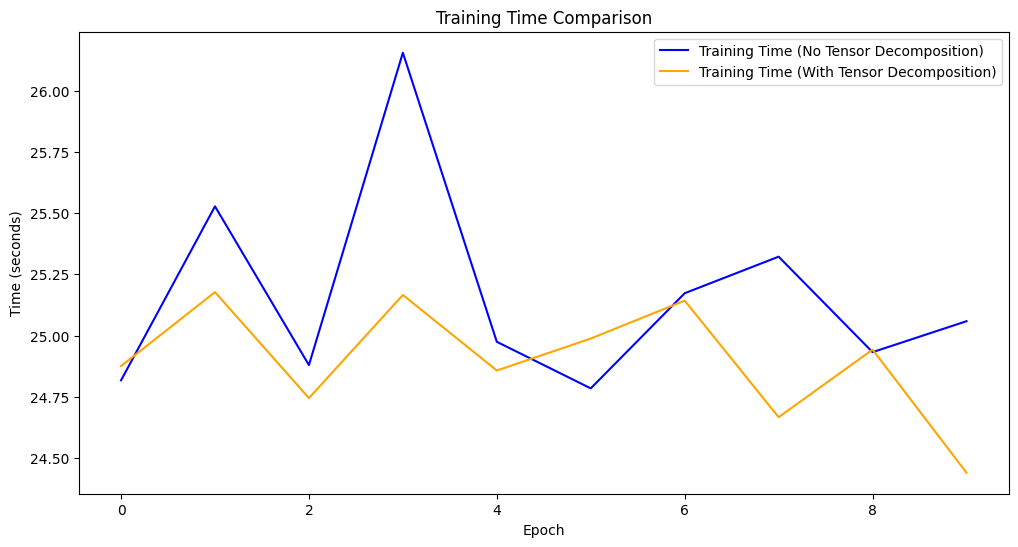

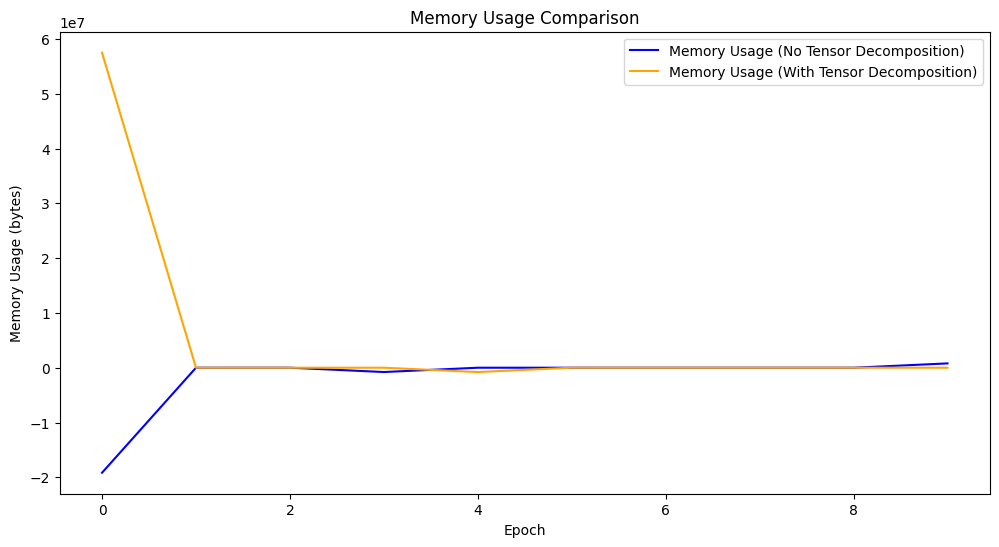

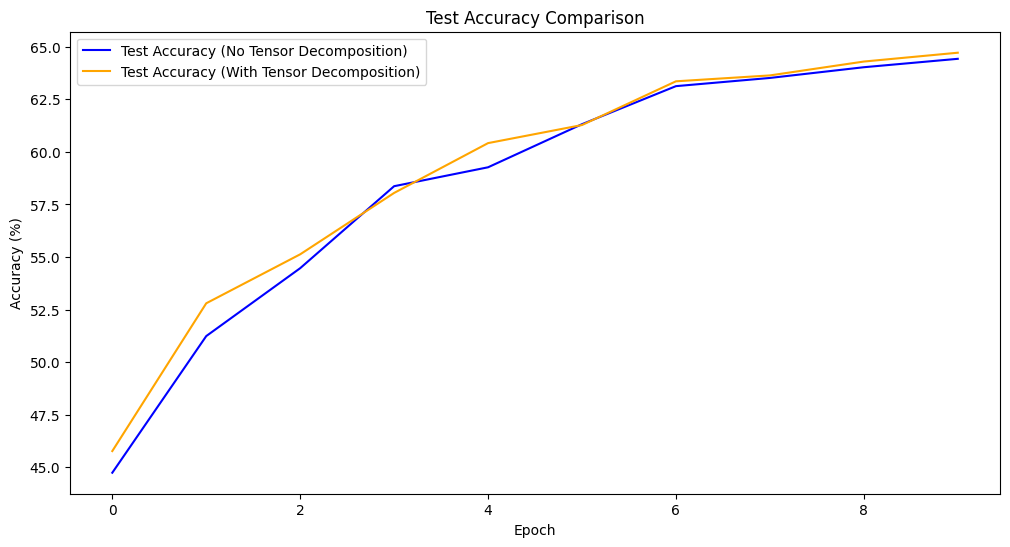

In [ ]:
import torch
import torch.nn as nn
import time
import psutil
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to measure memory usage
def get_memory_usage():
    memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else psutil.Process(os.getpid()).memory_info().rss
    return memory

# Transformer block with Tensor Decomposition-based low-rank approximation
class TransformerBlockTensorDecomp(nn.Module):
    def __init__(self, embed_dim, num_heads, rank=64):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.rank = rank  # Rank for low-rank approximation using Tensor Decomposition

    def forward(self, x):
        x2 = self.layernorm1(x)
        x = x + self.attn(x2, x2, x2)[0]  # Self-attention
        x2 = self.layernorm2(x)
        x = x + self.ff(x2)  # Feed forward
        return x

    def tensor_decomposition_approximation(self, attn_tensor):
        # Apply Tensor Decomposition for low-rank approximation
        u, s, v = torch.svd(attn_tensor.view(-1, attn_tensor.size(-1)))
        s = torch.diag(s)  # Create a diagonal matrix from singular values
        u = u[:, :self.rank]  # Keep the first 'rank' columns
        s = s[:self.rank, :self.rank]  # Keep the top 'rank' singular values
        v = v[:, :self.rank]  # Keep the first 'rank' rows

        # Reconstruct the low-rank approximation
        attn_tensor_low_rank = torch.matmul(u, torch.matmul(s, v.t()))
        return attn_tensor_low_rank

# Main model with Tensor Decomposition-based low-rank approximation blocks
class CustomVisionTransformerTensorDecomp(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10, rank=64):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes
        self.rank = rank

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockTensorDecomp(embed_dim, num_heads, rank) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Model without Tensor Decomposition-based low-rank approximation
class CustomVisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=256, num_heads=8, depth=6, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.depth = depth
        self.num_classes = num_classes

        self.embedding = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        self.blocks = nn.ModuleList([TransformerBlockTensorDecomp(embed_dim, num_heads) for _ in range(depth)])  # Same block as above
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches = self.extract_patches(x)
        x = self.embedding(patches)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Average over all patches
        x = self.fc(x)  # Classification

        return x

    def extract_patches(self, x):
        b, c, h, w = x.shape
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(b, c, -1, self.patch_size * self.patch_size)
        patches = patches.permute(0, 2, 1, 3).reshape(b, -1, self.patch_size * self.patch_size * c)
        return patches

# Load and prepare data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize models and optimizers
model = CustomVisionTransformer(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=10).to(device)
model_tensor_decomp = CustomVisionTransformerTensorDecomp(img_size=32, patch_size=8, embed_dim=256, num_heads=8, depth=6, num_classes=10, rank=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_tensor_decomp = torch.optim.Adam(model_tensor_decomp.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

# Variables to track time and memory
train_times_no_tensor_decomp, train_times_with_tensor_decomp = [], []
train_memories_no_tensor_decomp, train_memories_with_tensor_decomp = [], []
test_accuracies_no_tensor_decomp, test_accuracies_with_tensor_decomp = [], []

# Training models
for epoch in range(10):
    # Train model without Tensor Decomposition
    model.train()
    epoch_start_time_no_tensor_decomp = time.time()
    epoch_start_mem_no_tensor_decomp = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (no Tensor Decomposition)"):

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    epoch_end_time_no_tensor_decomp = time.time()
    epoch_end_mem_no_tensor_decomp = get_memory_usage()

    train_times_no_tensor_decomp.append(epoch_end_time_no_tensor_decomp - epoch_start_time_no_tensor_decomp)
    train_memories_no_tensor_decomp.append(epoch_end_mem_no_tensor_decomp - epoch_start_mem_no_tensor_decomp)

    # Test accuracy for model without Tensor Decomposition
    model.eval()
    correct_no_tensor_decomp, total_no_tensor_decomp = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_no_tensor_decomp += (predicted == labels).sum().item()

            total_no_tensor_decomp += labels.size(0)

    test_accuracy_no_tensor_decomp = correct_no_tensor_decomp / total_no_tensor_decomp * 100
    test_accuracies_no_tensor_decomp.append(test_accuracy_no_tensor_decomp)

    # Train model with Tensor Decomposition
    model_tensor_decomp.train()
    epoch_start_time_with_tensor_decomp = time.time()
    epoch_start_mem_with_tensor_decomp = get_memory_usage()

    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1} Training (with Tensor Decomposition)"):

        images, labels = images.to(device), labels.to(device)

        optimizer_tensor_decomp.zero_grad()
        outputs = model_tensor_decomp(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_tensor_decomp.step()

    epoch_end_time_with_tensor_decomp = time.time()
    epoch_end_mem_with_tensor_decomp = get_memory_usage()

    train_times_with_tensor_decomp.append(epoch_end_time_with_tensor_decomp - epoch_start_time_with_tensor_decomp)
    train_memories_with_tensor_decomp.append(epoch_end_mem_with_tensor_decomp - epoch_start_mem_with_tensor_decomp)

    # Test accuracy for model with Tensor Decomposition
    model_tensor_decomp.eval()
    correct_with_tensor_decomp, total_with_tensor_decomp = 0, 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_tensor_decomp(images)
            _, predicted = torch.max(outputs, 1)
            correct_with_tensor_decomp += (predicted == labels).sum().item()

            total_with_tensor_decomp += labels.size(0)

    test_accuracy_with_tensor_decomp = correct_with_tensor_decomp / total_with_tensor_decomp * 100
    test_accuracies_with_tensor_decomp.append(test_accuracy_with_tensor_decomp)

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(train_times_no_tensor_decomp, label='Training Time (No Tensor Decomposition)', color='blue')
plt.plot(train_times_with_tensor_decomp, label='Training Time (With Tensor Decomposition)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()
plt.title('Training Time Comparison')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_memories_no_tensor_decomp, label='Memory Usage (No Tensor Decomposition)', color='blue')
plt.plot(train_memories_with_tensor_decomp, label='Memory Usage (With Tensor Decomposition)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Memory Usage (bytes)')
plt.legend()
plt.title('Memory Usage Comparison')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_accuracies_no_tensor_decomp, label='Test Accuracy (No Tensor Decomposition)', color='blue')
plt.plot(test_accuracies_with_tensor_decomp, label='Test Accuracy (With Tensor Decomposition)', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Test Accuracy Comparison')
plt.show()